In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys

# Data Preparation

In [2]:
def prepare_data(path, split_ratio, seed):
    print("Data preparation has started.")
    np.random.seed(seed)
    print("Data import has started")
    try :
        df = pd.read_csv(path)
    except:
        print("Data file could not be found in given path. Please be sure the file exists in given path.")
        raise      
    else:
        data = df.to_numpy().astype(np.float32)
        print("Data import has finished")
        np.random.shuffle(data)
        X = data[:,1:]
        Y = data[:,0]
        splitPoint = round( len(Y)*split_ratio )
        train_x, train_y, test_x, test_y = X[:splitPoint], Y[:splitPoint], X[splitPoint:], Y[splitPoint:]
        print(f"Data has been splited according to ratio of {split_ratio}")
    
        print("Normalization has started")
        train_x /= 255.0
        test_x /= 255.0
        print("Completed")
        
        print("\nThe shapes of data is as following: ")
        print(f"Shape of train set of X is : {train_x.shape}")
        print(f"Shape of train set of Y is : {train_y.shape}")
        print(f"Shape of test set of X is : {test_x.shape}")
        print(f"Shape of test set of Y is: {test_y.shape}\n")
        
        return train_x, train_y, test_x, test_y

# TRAINING

In [3]:
def indicatorMatrix(y):
    N = len(y)
    y = y.astype(np.int32)
    K = y.max() + 1
    ind = np.zeros((N,K))
    for n in range(N):
        k = y[n]
        ind[n,k] = 1
    return ind

In [4]:
def forwardPropagation(X,W,b):
    Z = X.dot(W) + b
    expZ = np.exp(Z)
    return expZ / expZ.sum(axis = 1, keepdims = True)

In [19]:
def cost(p_y, t):
    tot = t * np.log(p_y)
    return -tot.sum()

In [6]:
def error_rate(p_y, t):
    prediction = predict(p_y)
    return np.mean(prediction != t)

In [7]:
def predict(p_y):
    return np.argmax(p_y, axis = 1)

In [8]:
def gradW(t, y, X):
    return X.T.dot(t - y)
def gradb(t, y):
    return (t - y).sum(axis = 0)

In [20]:
def getBatches(X,Y,batch_size):
    if batch_size == -1:
        batch_size = len(Y)
        
    batch_number = int(np.ceil( len(Y) / batch_size ))
    Xb, Yb = [None]*batch_number, [None]*batch_number
    for i in range(batch_number):
        Xb[i] = X[i*batch_size : (i+1)*batch_size ]
        Yb[i] = Y[i*batch_size : (i+1)*batch_size ]
    return Xb, Yb

In [21]:
def linearModel(path, split_ratio, seed, batch_size, learning_rate = 0.0001, regularization = 0.0, n_iter = 100):
    
    train_x, train_y, test_x, test_y = prepare_data(path, split_ratio, seed)
    
    M, NX = train_x.shape
    train_indicatorMatrix = indicatorMatrix(train_y)
    K = train_indicatorMatrix.shape[1]
    print(f"Target number is {K}")
    print(f"Train ind matrix is : {train_indicatorMatrix.shape}")
    
    print("Initialization of weight matrix and bias vector has started...\n")
    W = np.random.randn(NX,K) / np.sqrt(NX)
    print(f"Shape of W is {W.shape}")
    b = np.zeros(K)
    print(f"Shape of b is {b.shape}")
    print("\nInitialization of weight matrix and bias vector has COMPLETED\n")
    
    train_losses, test_losses, train_error, test_error = [],[],[],[]
    
    print("Training has started.\n")
    
    if batch_size == -1:
        print(f"Full Gradient Descent has chosen by user.")
    elif batch_size == 1:
        print(f"Stocastic Gradient Descent has chosen by user.")
    else:
        print(f"Mini-Batch Gradient Descent has chosen by user.")
        
    for i in range(n_iter):
        
        if batch_size != -1:
            
            permutation = np.random.permutation(len(train_x))            
            train_x, train_y = train_x[permutation], train_y[permutation]
            train_indicatorMatrix = indicatorMatrix(train_y)
            
        Xb, Yb = getBatches(train_x, train_y, batch_size)
        c = 0
        for X, Y in zip(Xb, Yb): 
            
            if batch_size != -1:
                train_indicatorMatrix_batch = train_indicatorMatrix[c*len(X):(c+1)*len(X)]
            else :
                train_indicatorMatrix_batch = train_indicatorMatrix
            
            
            p_y = forwardPropagation(X, W, b)
            trainLoss = cost(p_y, train_indicatorMatrix_batch)
            train_losses.append(trainLoss)
            trainError = error_rate(p_y, Y)
            train_error.append(trainError)
            
            W += learning_rate*(gradW( train_indicatorMatrix_batch, p_y, X) - regularization*W)
            b += learning_rate*(gradb( train_indicatorMatrix_batch, p_y ))
            c+=1
             
        if (i+1)%10 == 0:
            print(f"Iteration : {i+1} Train Loss : {trainLoss:.3f} Train Error : {trainError:.3f}")
        
    p_y = forwardPropagation(test_x, W, b)
    test_indicatorMatrix = indicatorMatrix(test_y)
    
    print("Training has finished.\n")
    print(f"Final error rate is {error_rate(p_y, test_y)}")
    
    results = {
        "test_error_rate": error_rate(p_y, test_y),
        "test_cost": cost(p_y, test_indicatorMatrix),
        "costs": train_losses,
        "errors": train_error,
        "w" : W,
        "b" : b,
        "n_iter" : n_iter,
        "batch_size" : batch_size
    }
    
    return results

In [11]:
def plot_model(results):
    for c,result in enumerate(results):
        plt.plot(result["costs"], label = f"Cost of Model {c}")
        plt.suptitle(f"Batch size {result['batch_size']} and Iteration number {result['n_iter']}")
    plt.title("Loss per iteration")
    plt.legend()
    plt.show()
    
    for c,result in enumerate(results):
        plt.plot(result["errors"], label = f"Train Error of Model {c}")
    plt.title("Loss per iteration")
    plt.legend()
    plt.show()

In [22]:
res = linearModel("train.csv", 0.7, 10, 1, learning_rate = 0.0003, regularization = 0.0, n_iter = 10)

Data preparation has started.
Data import has started
Data import has finished
Data has been splited according to ratio of 0.7
Normalization has started
Completed

The shapes of data is as following: 
Shape of train set of X is : (29400, 784)
Shape of train set of Y is : (29400,)
Shape of test set of X is : (12600, 784)
Shape of test set of Y is: (12600,)

Target number is 10
Train ind matrix is : (29400, 10)
Initialization of weight matrix and bias vector has started...

Shape of W is (784, 10)
Shape of b is (10,)

Initialization of weight matrix and bias vector has COMPLETED

Training has started.

Stocastic Gradient Descent has chosen by user.
Iteration : 10 Train Loss : 0.110 Train Error : 0.000
Training has finished.

Final error rate is 0.0992063492063492


In [23]:
res2 = linearModel("train.csv", 0.7, 10, -1, learning_rate = 0.0003, regularization = 0.0, n_iter = 10)

Data preparation has started.
Data import has started
Data import has finished
Data has been splited according to ratio of 0.7
Normalization has started
Completed

The shapes of data is as following: 
Shape of train set of X is : (29400, 784)
Shape of train set of Y is : (29400,)
Shape of test set of X is : (12600, 784)
Shape of test set of Y is: (12600,)

Target number is 10
Train ind matrix is : (29400, 10)
Initialization of weight matrix and bias vector has started...

Shape of W is (784, 10)
Shape of b is (10,)

Initialization of weight matrix and bias vector has COMPLETED

Training has started.

Full Gradient Descent has chosen by user.
Iteration : 10 Train Loss : 684406.612 Train Error : 0.405
Training has finished.

Final error rate is 0.395


In [24]:
res3 = linearModel("train.csv", 0.7, 10, 1000, learning_rate = 0.0003, regularization = 0.0, n_iter = 10)

Data preparation has started.
Data import has started
Data import has finished
Data has been splited according to ratio of 0.7
Normalization has started
Completed

The shapes of data is as following: 
Shape of train set of X is : (29400, 784)
Shape of train set of Y is : (29400,)
Shape of test set of X is : (12600, 784)
Shape of test set of Y is: (12600,)

Target number is 10
Train ind matrix is : (29400, 10)
Initialization of weight matrix and bias vector has started...

Shape of W is (784, 10)
Shape of b is (10,)

Initialization of weight matrix and bias vector has COMPLETED

Training has started.

Mini-Batch Gradient Descent has chosen by user.
Iteration : 10 Train Loss : 2471.114 Train Error : 0.092
Training has finished.

Final error rate is 0.10047619047619048


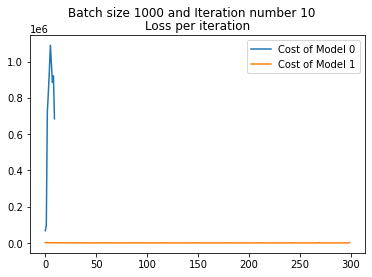

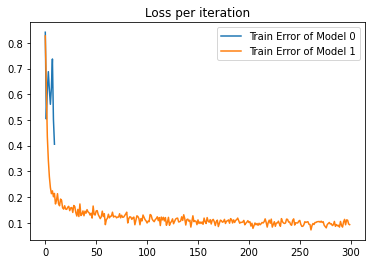

In [26]:
results = []
#results.append(res)
results.append(res2)
results.append(res3)
plot_model(results)